## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [54]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [55]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [56]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [57]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [58]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [59]:
#treatment in group will be called A and new_page in landing_page will be called B
df_A_not_B = df.query('group == "treatment" & landing_page != "new_page"')
df_B_not_A = df.query('group != "treatment" & landing_page == "new_page"')

#calculate thenumber of time new_page and treatment don't line up
df_A_not_B.count() + df_B_not_A.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [60]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

As shown above, there is no any missing values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [61]:
#dataframe in which old_page and control line up.
df_1= df.query('group == "control" & landing_page == "old_page"')

#dataframe in which new_page and treatment line up.
df_2 = df.query('group == "treatment" & landing_page == "new_page"')

#appendind both datafarames
df2 = df_2.append(df_1)

In [62]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [63]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [64]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [65]:
df2[df2['user_id']==773192].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1899 to 2893
Data columns (total 5 columns):
user_id         2 non-null int64
timestamp       2 non-null object
group           2 non-null object
landing_page    2 non-null object
converted       2 non-null int64
dtypes: int64(2), object(3)
memory usage: 96.0+ bytes


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [66]:
#removing row 2893
df2.drop(2893, inplace=True)

In [67]:
#assuring the removal of row 2893
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [68]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [69]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [70]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [71]:
(df2['landing_page']=='new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**From from the above, we conclude the follwoing:**
- Almost 50% of the population received the new page
- 12% of the group 'control' converted
- 11.8% of the group 'treatment' converted

**From this conclusion, we can see that the old page is dominating. However the difference is very small, so we cannot build our decision based on our results so far.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [72]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [73]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [74]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [75]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [76]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
new_page_converted.mean()

0.11876677448214162

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [77]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean()

0.11836254250588543

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [78]:
(new_page_converted.mean()) - (old_page_converted.mean())

0.00040423197625619189

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [79]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [80]:
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')

#calculating observed difference
obs_diff = df_treatment.converted.mean() - df_control.converted.mean()

#converting p_diffss to numpy array
p_diffs = np.asarray(p_diffs)

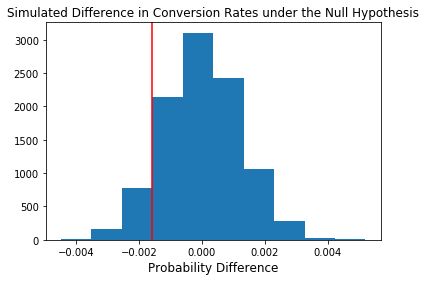

In [81]:
#plotting a histogram
plt.hist(p_diffs)
plt.title("Simulated Difference in Conversion Rates under the Null Hypothesis", fontsize=12)
plt.xlabel("Probability Difference", fontsize=12)
plt.axvline(obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [83]:
(p_diffs > obs_diff).mean()

0.90590000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Based on the analysis performed, it was noted the following:**
-  probability of the statistic (p_diff) is higher than the actual difference observed in our dataset by 90.59%
- In other words, our P-Value is 0.9, which is too high for us to reject the null hypothesis.
- There is no sufficient evidence demonstrates that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

convert_old ,n_old , convert_new , n_new

(17489, 145274, 17264, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [85]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Based on the above analsys, it was noted the following:**
- The Z-Score is smaller than the the critical value (p_value)
- This result agree with the previous conclusion as we still can not reject null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [86]:
# checking few rows of our data
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [87]:
# adding intercept column
df2['intercept']=1

# adding columns from get_dummies
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

# checking a few rows
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


In [88]:
# dropping the control column added in the previous step
df2 = df2.drop('control', axis=1)

# checking a few rows
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [89]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [90]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-23 01:02 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

- The p-value associated with the ab_page is 0.1899.
- It differs from the value found in Part 2, because Logistic Regression is based on a two-tailed test.
- Since the returned p-value associated with ab_page column is still greater than the typical $\alpha$ level, we would still fail to reject the null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- **Advantages:** The convert rate may be related to some features of users like nationality, age, gender or specific cultural behavior. Adding additional information about users could reveal hidden value of the new version of the page for specific group of the users.
- **Disadvantages:** This requires having enough participants with each possible set of explanatory variable added to the regression model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [91]:
#Reading the countries.csv Dataset
df_countries = pd.read_csv('./countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [92]:
#Merging the 2 datasets
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [93]:
#checking the unique values of country column
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [94]:
#Creating the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [95]:
# Train the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'uk', 'us']])
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-23 01:02 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
uk             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
us             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

The p-values for the countries are above 0.05, so we still cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [96]:
# Creating additional columns for user/country converted
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [97]:
#train the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-23 01:02 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
us             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
uk             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
us_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
uk_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

- According to the summary results above, None of the p-values associated with the variables is below the $\alpha$ level.\, which means that we fail to reject the Null Hypothesis
- Also, there is  no sufficient evidence suggesting that there is an interaction between country and page received that will predict whether a user converts or not.

## Conclusion

- Based on the probability figures, A/B test and regression, there is no enough evidence that the new page increases the conversion rate compared to the old page
- There is no enough evidence that the countries US, or UK influence the conversion rate
- Based on the analysis performed, we fail to reject the Null Hypothesis. Accordingly, we fail to recommend to remove the old page and apply the new one

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [98]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0